# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

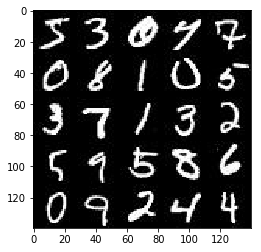

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

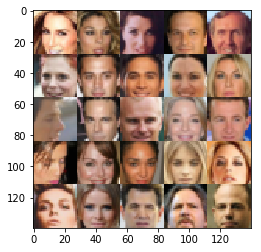

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instan

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x out_channel_dim
        #print(images.get_shape().as_list())
        
        # conv to 14, 14, 128
        x = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # conv to 7, 7, 256
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same', use_bias=False)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # conv to 4, 4, 512
        x = tf.layers.conv2d(x, 512, 5, strides=2, padding='same', use_bias=False)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # flatten
        x = tf.reshape(x, (-1, 4*4*512))
        #print(x.get_shape().as_list())
        
        # logits and output
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.02): # I put alpha parameter to this function call
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    
    # auxiliar variables
    reuse = not is_train
    
    # scope for generator
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 2*2*512)
        #print(x.get_shape().as_list())
        
        # batch normalization to 2x2x512
        x = tf.reshape(x, (-1, 2, 2, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # conv to 4x4x256
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # conv to 7x7x128
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=1, padding='valid')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())        
            
        # conv to 14x14x64        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # Output layer, 28 x 28 x out_channel_dim (3 or 1, depending on the task - faces or minst)
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.get_shape().as_list())
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
smooth = 0.1

def model_loss(input_real, input_z, out_channel_dim, alpha=0.02): # I put alpha parameter to this function call
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    
    # Just for reference:
    #   discriminator(images, reuse=False, alpha=0.01)
    #   generator(z, out_channel_dim, is_train=True, alpha=0.02): # I put alpha parameter to this function call
    
    g_out = generator(input_z, out_channel_dim, alpha=alpha)
    d_out_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_real,
                                                        labels=tf.ones_like(d_out_real) * (1. - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_fake,
                                                        labels=tf.zeros_like(d_out_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_fake,
                                                        labels=tf.ones_like(d_out_fake)))

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
from datetime import datetime

print_every = 10
show_every = 100
n_images = 16
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model
    minput_real, minput_z, mlearning_rate = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(minput_real, minput_z, data_shape[-1], alpha=0.02)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    have_i_already_reset_the_default_graph = True

    # Auxiliar variables
    steps = 0
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    sample_z = np.random.uniform(-1, 1, size=(n_images, z_dim))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):    
            for batch_images in get_batches(batch_size):
                # DONE: Train Model
                steps += 1
                
                # rescale from [-.5, .5] to [-1., 1.]
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={minput_real: batch_images, minput_z: batch_z, mlearning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={minput_z: batch_z, mlearning_rate: learning_rate, minput_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({minput_z: batch_z, minput_real: batch_images})
                    train_loss_g = g_loss.eval({minput_z: batch_z})

                    print("Timestamp {} - ".format(datetime.now().strftime('%Y%m%d-%H-%M-%S.%f')[:-3]),
                          "Epoch {}/{} - ".format(epoch_i+1, epochs),
                          "Step {} - ".format(steps),
                          "D Loss: {:.4f} -".format(train_loss_d),
                          "G Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, minput_z, out_channel_dim, data_image_mode)

            # At the end of each epoch, get the losses and print them out
            if not (steps % show_every == 0):
                train_loss_d = d_loss.eval({minput_z: batch_z, minput_real: batch_images})
                train_loss_g = g_loss.eval({minput_z: batch_z})
                print("Timestamp {} - ".format(datetime.now().strftime('%Y%m%d-%H-%M-%S.%f')[:-3]),
                      "Epoch {}/{} - ".format(epoch_i+1, epochs),
                      "Step {} - ".format(steps),
                      "D Loss: {:.4f} -".format(train_loss_d),
                      "G Loss: {:.4f}".format(train_loss_g))

                show_generator_output(sess, n_images, minput_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Timestamp 20170802-00-40-06.024 -  Epoch 1/2 -  Step 10 -  D Loss: 4.4067 - G Loss: 12.1534
Timestamp 20170802-00-40-25.959 -  Epoch 1/2 -  Step 20 -  D Loss: 1.9710 - G Loss: 0.2412
Timestamp 20170802-00-40-46.001 -  Epoch 1/2 -  Step 30 -  D Loss: 0.6446 - G Loss: 6.3264
Timestamp 20170802-00-41-05.325 -  Epoch 1/2 -  Step 40 -  D Loss: 2.5163 - G Loss: 17.9059
Timestamp 20170802-00-41-25.004 -  Epoch 1/2 -  Step 50 -  D Loss: 2.4151 - G Loss: 5.5484
Timestamp 20170802-00-41-44.848 -  Epoch 1/2 -  Step 60 -  D Loss: 0.6621 - G Loss: 2.2521
Timestamp 20170802-00-42-04.694 -  Epoch 1/2 -  Step 70 -  D Loss: 1.0425 - G Loss: 5.6147
Timestamp 20170802-00-42-24.650 -  Epoch 1/2 -  Step 80 -  D Loss: 0.7785 - G Loss: 2.0480
Timestamp 20170802-00-42-44.376 -  Epoch 1/2 -  Step 90 -  D Loss: 0.4566 - G Loss: 3.1466
Timestamp 20170802-00-43-03.992 -  Epoch 1/2 -  Step 100 -  D Loss: 0.4677 - G Loss: 3.3662


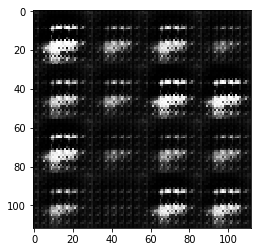

Timestamp 20170802-00-43-24.595 -  Epoch 1/2 -  Step 110 -  D Loss: 0.6193 - G Loss: 2.2673
Timestamp 20170802-00-43-44.666 -  Epoch 1/2 -  Step 120 -  D Loss: 0.4493 - G Loss: 3.4379
Timestamp 20170802-00-44-04.459 -  Epoch 1/2 -  Step 130 -  D Loss: 0.8087 - G Loss: 1.9366
Timestamp 20170802-00-44-24.341 -  Epoch 1/2 -  Step 140 -  D Loss: 0.8824 - G Loss: 0.9862
Timestamp 20170802-00-44-44.095 -  Epoch 1/2 -  Step 150 -  D Loss: 1.9286 - G Loss: 9.4988
Timestamp 20170802-00-45-03.825 -  Epoch 1/2 -  Step 160 -  D Loss: 1.4360 - G Loss: 0.5956
Timestamp 20170802-00-45-23.898 -  Epoch 1/2 -  Step 170 -  D Loss: 0.4327 - G Loss: 3.9442
Timestamp 20170802-00-45-44.126 -  Epoch 1/2 -  Step 180 -  D Loss: 0.4146 - G Loss: 6.7196
Timestamp 20170802-00-46-03.598 -  Epoch 1/2 -  Step 190 -  D Loss: 0.4368 - G Loss: 3.4928
Timestamp 20170802-00-46-23.197 -  Epoch 1/2 -  Step 200 -  D Loss: 0.4595 - G Loss: 3.7115


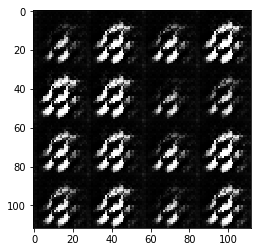

Timestamp 20170802-00-46-43.490 -  Epoch 1/2 -  Step 210 -  D Loss: 0.6168 - G Loss: 1.7412
Timestamp 20170802-00-47-03.368 -  Epoch 1/2 -  Step 220 -  D Loss: 0.4575 - G Loss: 3.1880
Timestamp 20170802-00-47-23.091 -  Epoch 1/2 -  Step 230 -  D Loss: 0.4923 - G Loss: 4.5550
Timestamp 20170802-00-47-42.874 -  Epoch 1/2 -  Step 240 -  D Loss: 0.4185 - G Loss: 3.3966
Timestamp 20170802-00-48-04.285 -  Epoch 1/2 -  Step 250 -  D Loss: 0.4101 - G Loss: 6.3316
Timestamp 20170802-00-48-25.562 -  Epoch 1/2 -  Step 260 -  D Loss: 0.6520 - G Loss: 6.0508
Timestamp 20170802-00-48-46.445 -  Epoch 1/2 -  Step 270 -  D Loss: 0.7042 - G Loss: 6.8841
Timestamp 20170802-00-49-06.941 -  Epoch 1/2 -  Step 280 -  D Loss: 0.5811 - G Loss: 2.1554
Timestamp 20170802-00-49-27.583 -  Epoch 1/2 -  Step 290 -  D Loss: 0.4724 - G Loss: 3.5192
Timestamp 20170802-00-49-47.408 -  Epoch 1/2 -  Step 300 -  D Loss: 0.4685 - G Loss: 2.9710


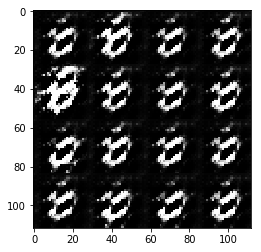

KeyboardInterrupt: 

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Timestamp 20170802-00-50-44.338 -  Epoch 1/2 -  Step 10 -  D Loss: 0.6822 - G Loss: 25.8207
Timestamp 20170802-00-50-54.899 -  Epoch 1/2 -  Step 20 -  D Loss: 0.3992 - G Loss: 8.8277
Timestamp 20170802-00-51-05.460 -  Epoch 1/2 -  Step 30 -  D Loss: 1.1461 - G Loss: 12.8476
Timestamp 20170802-00-51-16.008 -  Epoch 1/2 -  Step 40 -  D Loss: 12.5512 - G Loss: 0.0343
Timestamp 20170802-00-51-26.557 -  Epoch 1/2 -  Step 50 -  D Loss: 0.7271 - G Loss: 3.5043
Timestamp 20170802-00-51-37.102 -  Epoch 1/2 -  Step 60 -  D Loss: 2.5729 - G Loss: 0.9989
Timestamp 20170802-00-51-47.638 -  Epoch 1/2 -  Step 70 -  D Loss: 0.7852 - G Loss: 4.1309
Timestamp 20170802-00-51-58.194 -  Epoch 1/2 -  Step 80 -  D Loss: 1.0758 - G Loss: 2.9314
Timestamp 20170802-00-52-08.770 -  Epoch 1/2 -  Step 90 -  D Loss: 0.4601 - G Loss: 3.5827
Timestamp 20170802-00-52-19.311 -  Epoch 1/2 -  Step 100 -  D Loss: 2.4713 - G Loss: 1.0122


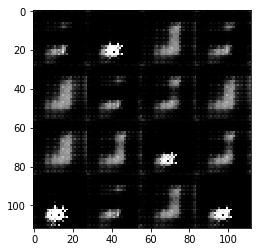

Timestamp 20170802-00-52-30.361 -  Epoch 1/2 -  Step 110 -  D Loss: 0.5407 - G Loss: 3.3030
Timestamp 20170802-00-52-40.947 -  Epoch 1/2 -  Step 120 -  D Loss: 0.4966 - G Loss: 2.8117
Timestamp 20170802-00-52-51.560 -  Epoch 1/2 -  Step 130 -  D Loss: 0.4833 - G Loss: 4.3343
Timestamp 20170802-00-53-02.116 -  Epoch 1/2 -  Step 140 -  D Loss: 0.5026 - G Loss: 4.6117
Timestamp 20170802-00-53-12.671 -  Epoch 1/2 -  Step 150 -  D Loss: 0.7664 - G Loss: 1.7794
Timestamp 20170802-00-53-23.195 -  Epoch 1/2 -  Step 160 -  D Loss: 2.0703 - G Loss: 0.2495
Timestamp 20170802-00-53-33.736 -  Epoch 1/2 -  Step 170 -  D Loss: 0.6702 - G Loss: 2.4454
Timestamp 20170802-00-53-44.406 -  Epoch 1/2 -  Step 180 -  D Loss: 0.4559 - G Loss: 5.4329
Timestamp 20170802-00-53-54.983 -  Epoch 1/2 -  Step 190 -  D Loss: 0.9732 - G Loss: 0.9761
Timestamp 20170802-00-54-05.529 -  Epoch 1/2 -  Step 200 -  D Loss: 0.5375 - G Loss: 2.5954


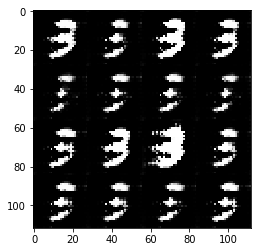

Timestamp 20170802-00-54-16.606 -  Epoch 1/2 -  Step 210 -  D Loss: 1.4196 - G Loss: 0.9244
Timestamp 20170802-00-54-27.169 -  Epoch 1/2 -  Step 220 -  D Loss: 0.4722 - G Loss: 3.5165
Timestamp 20170802-00-54-37.777 -  Epoch 1/2 -  Step 230 -  D Loss: 0.4374 - G Loss: 3.4203
Timestamp 20170802-00-54-48.335 -  Epoch 1/2 -  Step 240 -  D Loss: 0.5232 - G Loss: 4.0766
Timestamp 20170802-00-54-58.906 -  Epoch 1/2 -  Step 250 -  D Loss: 0.4252 - G Loss: 4.1607
Timestamp 20170802-00-55-09.456 -  Epoch 1/2 -  Step 260 -  D Loss: 0.3768 - G Loss: 4.2495
Timestamp 20170802-00-55-20.066 -  Epoch 1/2 -  Step 270 -  D Loss: 1.1153 - G Loss: 7.8272
Timestamp 20170802-00-55-30.634 -  Epoch 1/2 -  Step 280 -  D Loss: 1.0770 - G Loss: 1.4498
Timestamp 20170802-00-55-41.169 -  Epoch 1/2 -  Step 290 -  D Loss: 0.5998 - G Loss: 3.7134
Timestamp 20170802-00-55-51.728 -  Epoch 1/2 -  Step 300 -  D Loss: 0.4539 - G Loss: 4.2478


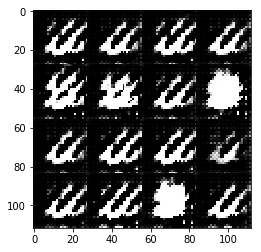

Timestamp 20170802-00-56-02.829 -  Epoch 1/2 -  Step 310 -  D Loss: 0.4365 - G Loss: 3.1360
Timestamp 20170802-00-56-13.382 -  Epoch 1/2 -  Step 320 -  D Loss: 1.2472 - G Loss: 0.8286
Timestamp 20170802-00-56-23.938 -  Epoch 1/2 -  Step 330 -  D Loss: 0.4249 - G Loss: 3.9441
Timestamp 20170802-00-56-34.487 -  Epoch 1/2 -  Step 340 -  D Loss: 0.5037 - G Loss: 2.9181
Timestamp 20170802-00-56-45.029 -  Epoch 1/2 -  Step 350 -  D Loss: 0.5512 - G Loss: 2.7597
Timestamp 20170802-00-56-55.546 -  Epoch 1/2 -  Step 360 -  D Loss: 0.4209 - G Loss: 3.4036
Timestamp 20170802-00-57-06.049 -  Epoch 1/2 -  Step 370 -  D Loss: 0.3766 - G Loss: 4.4579
Timestamp 20170802-00-57-16.571 -  Epoch 1/2 -  Step 380 -  D Loss: 0.6702 - G Loss: 5.0511
Timestamp 20170802-00-57-27.107 -  Epoch 1/2 -  Step 390 -  D Loss: 0.5025 - G Loss: 4.8486
Timestamp 20170802-00-57-37.665 -  Epoch 1/2 -  Step 400 -  D Loss: 1.0390 - G Loss: 0.9195


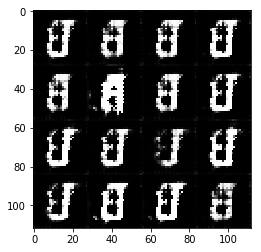

Timestamp 20170802-00-57-48.862 -  Epoch 1/2 -  Step 410 -  D Loss: 0.6627 - G Loss: 5.8245
Timestamp 20170802-00-57-59.396 -  Epoch 1/2 -  Step 420 -  D Loss: 1.7209 - G Loss: 5.6015
Timestamp 20170802-00-58-10.052 -  Epoch 1/2 -  Step 430 -  D Loss: 0.3900 - G Loss: 5.1760
Timestamp 20170802-00-58-20.602 -  Epoch 1/2 -  Step 440 -  D Loss: 1.0076 - G Loss: 0.7864
Timestamp 20170802-00-58-31.178 -  Epoch 1/2 -  Step 450 -  D Loss: 0.8475 - G Loss: 2.2516
Timestamp 20170802-00-58-41.712 -  Epoch 1/2 -  Step 460 -  D Loss: 0.4346 - G Loss: 2.8689
Timestamp 20170802-00-58-52.239 -  Epoch 1/2 -  Step 470 -  D Loss: 0.8530 - G Loss: 1.8766
Timestamp 20170802-00-59-02.799 -  Epoch 1/2 -  Step 480 -  D Loss: 0.5681 - G Loss: 2.4971
Timestamp 20170802-00-59-13.343 -  Epoch 1/2 -  Step 490 -  D Loss: 0.4631 - G Loss: 2.7996
Timestamp 20170802-00-59-23.912 -  Epoch 1/2 -  Step 500 -  D Loss: 0.4918 - G Loss: 3.0657


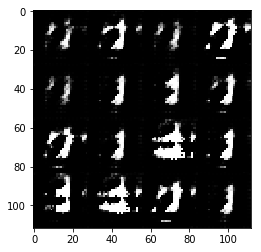

Timestamp 20170802-00-59-35.166 -  Epoch 1/2 -  Step 510 -  D Loss: 0.4823 - G Loss: 2.9093
Timestamp 20170802-00-59-45.701 -  Epoch 1/2 -  Step 520 -  D Loss: 0.5070 - G Loss: 2.5362
Timestamp 20170802-00-59-56.243 -  Epoch 1/2 -  Step 530 -  D Loss: 0.8576 - G Loss: 2.0253
Timestamp 20170802-01-00-06.815 -  Epoch 1/2 -  Step 540 -  D Loss: 0.5283 - G Loss: 2.9178
Timestamp 20170802-01-00-17.398 -  Epoch 1/2 -  Step 550 -  D Loss: 0.4626 - G Loss: 3.0535
Timestamp 20170802-01-00-27.941 -  Epoch 1/2 -  Step 560 -  D Loss: 0.6041 - G Loss: 2.6613
Timestamp 20170802-01-00-38.450 -  Epoch 1/2 -  Step 570 -  D Loss: 1.0602 - G Loss: 0.9813
Timestamp 20170802-01-00-48.981 -  Epoch 1/2 -  Step 580 -  D Loss: 1.0151 - G Loss: 1.0987
Timestamp 20170802-01-00-59.520 -  Epoch 1/2 -  Step 590 -  D Loss: 0.4611 - G Loss: 3.3588
Timestamp 20170802-01-01-10.067 -  Epoch 1/2 -  Step 600 -  D Loss: 0.4628 - G Loss: 3.5501


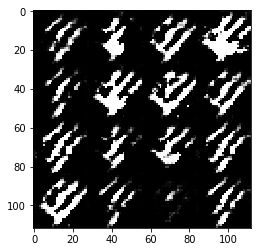

Timestamp 20170802-01-01-21.345 -  Epoch 1/2 -  Step 610 -  D Loss: 0.5036 - G Loss: 3.1959
Timestamp 20170802-01-01-32.923 -  Epoch 1/2 -  Step 620 -  D Loss: 0.4167 - G Loss: 3.4326
Timestamp 20170802-01-01-44.557 -  Epoch 1/2 -  Step 630 -  D Loss: 0.6574 - G Loss: 1.6173
Timestamp 20170802-01-01-56.280 -  Epoch 1/2 -  Step 640 -  D Loss: 0.4224 - G Loss: 3.8493
Timestamp 20170802-01-02-07.747 -  Epoch 1/2 -  Step 650 -  D Loss: 1.2983 - G Loss: 0.8436
Timestamp 20170802-01-02-19.732 -  Epoch 1/2 -  Step 660 -  D Loss: 0.5693 - G Loss: 2.3266
Timestamp 20170802-01-02-31.489 -  Epoch 1/2 -  Step 670 -  D Loss: 0.6058 - G Loss: 2.3614
Timestamp 20170802-01-02-43.204 -  Epoch 1/2 -  Step 680 -  D Loss: 0.6110 - G Loss: 2.1990


KeyboardInterrupt: 

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Timestamp 20170802-01-03-28.907 -  Epoch 1/2 -  Step 10 -  D Loss: 1.9694 - G Loss: 12.9710
Timestamp 20170802-01-03-39.516 -  Epoch 1/2 -  Step 20 -  D Loss: 21.1821 - G Loss: 34.4050
Timestamp 20170802-01-03-50.063 -  Epoch 1/2 -  Step 30 -  D Loss: 1.6219 - G Loss: 4.8176
Timestamp 20170802-01-04-00.650 -  Epoch 1/2 -  Step 40 -  D Loss: 2.8622 - G Loss: 5.1401
Timestamp 20170802-01-04-11.210 -  Epoch 1/2 -  Step 50 -  D Loss: 5.2437 - G Loss: 0.9965
Timestamp 20170802-01-04-21.848 -  Epoch 1/2 -  Step 60 -  D Loss: 1.9849 - G Loss: 1.8713
Timestamp 20170802-01-04-32.411 -  Epoch 1/2 -  Step 70 -  D Loss: 2.6328 - G Loss: 0.1641
Timestamp 20170802-01-04-42.997 -  Epoch 1/2 -  Step 80 -  D Loss: 0.5453 - G Loss: 2.3137
Timestamp 20170802-01-04-53.544 -  Epoch 1/2 -  Step 90 -  D Loss: 0.6990 - G Loss: 2.4524
Timestamp 20170802-01-05-04.085 -  Epoch 1/2 -  Step 100 -  D Loss: 0.4259 - G Loss: 4.6959


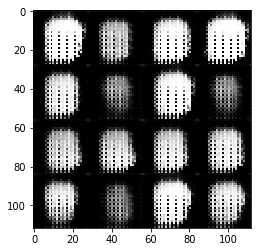

Timestamp 20170802-01-05-15.187 -  Epoch 1/2 -  Step 110 -  D Loss: 0.4153 - G Loss: 3.6331
Timestamp 20170802-01-05-25.775 -  Epoch 1/2 -  Step 120 -  D Loss: 0.9658 - G Loss: 1.2677
Timestamp 20170802-01-05-36.324 -  Epoch 1/2 -  Step 130 -  D Loss: 0.4672 - G Loss: 3.3476
Timestamp 20170802-01-05-46.860 -  Epoch 1/2 -  Step 140 -  D Loss: 0.4098 - G Loss: 4.0004
Timestamp 20170802-01-05-57.416 -  Epoch 1/2 -  Step 150 -  D Loss: 4.6904 - G Loss: 9.5168
Timestamp 20170802-01-06-07.916 -  Epoch 1/2 -  Step 160 -  D Loss: 0.7374 - G Loss: 2.0977
Timestamp 20170802-01-06-18.456 -  Epoch 1/2 -  Step 170 -  D Loss: 0.4475 - G Loss: 2.9128
Timestamp 20170802-01-06-29.049 -  Epoch 1/2 -  Step 180 -  D Loss: 0.5357 - G Loss: 2.0952
Timestamp 20170802-01-06-39.665 -  Epoch 1/2 -  Step 190 -  D Loss: 0.3888 - G Loss: 3.9933
Timestamp 20170802-01-06-50.244 -  Epoch 1/2 -  Step 200 -  D Loss: 3.4907 - G Loss: 8.4310


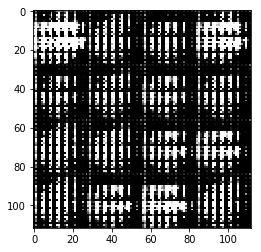

Timestamp 20170802-01-07-01.731 -  Epoch 1/2 -  Step 210 -  D Loss: 0.5065 - G Loss: 2.5877
Timestamp 20170802-01-07-12.269 -  Epoch 1/2 -  Step 220 -  D Loss: 1.3281 - G Loss: 0.6492
Timestamp 20170802-01-07-22.841 -  Epoch 1/2 -  Step 230 -  D Loss: 1.0550 - G Loss: 3.6119
Timestamp 20170802-01-07-33.413 -  Epoch 1/2 -  Step 240 -  D Loss: 0.4502 - G Loss: 3.0621
Timestamp 20170802-01-07-43.949 -  Epoch 1/2 -  Step 250 -  D Loss: 0.4111 - G Loss: 3.3911
Timestamp 20170802-01-07-54.489 -  Epoch 1/2 -  Step 260 -  D Loss: 0.3790 - G Loss: 3.8645
Timestamp 20170802-01-08-05.044 -  Epoch 1/2 -  Step 270 -  D Loss: 0.4179 - G Loss: 4.4483
Timestamp 20170802-01-08-15.636 -  Epoch 1/2 -  Step 280 -  D Loss: 0.6749 - G Loss: 1.7163
Timestamp 20170802-01-08-26.167 -  Epoch 1/2 -  Step 290 -  D Loss: 0.6702 - G Loss: 2.6776
Timestamp 20170802-01-08-36.696 -  Epoch 1/2 -  Step 300 -  D Loss: 0.4857 - G Loss: 3.0289


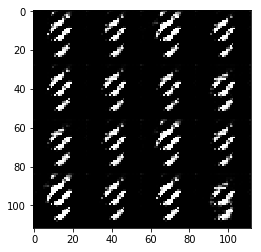

Timestamp 20170802-01-08-47.795 -  Epoch 1/2 -  Step 310 -  D Loss: 0.6371 - G Loss: 1.8254
Timestamp 20170802-01-08-58.339 -  Epoch 1/2 -  Step 320 -  D Loss: 0.4596 - G Loss: 2.4932
Timestamp 20170802-01-09-08.907 -  Epoch 1/2 -  Step 330 -  D Loss: 1.6709 - G Loss: 6.0836
Timestamp 20170802-01-09-19.512 -  Epoch 1/2 -  Step 340 -  D Loss: 0.4841 - G Loss: 2.7667
Timestamp 20170802-01-09-30.048 -  Epoch 1/2 -  Step 350 -  D Loss: 0.6884 - G Loss: 5.1622
Timestamp 20170802-01-09-40.639 -  Epoch 1/2 -  Step 360 -  D Loss: 0.5779 - G Loss: 4.8563
Timestamp 20170802-01-09-51.202 -  Epoch 1/2 -  Step 370 -  D Loss: 0.5800 - G Loss: 2.0082
Timestamp 20170802-01-10-01.761 -  Epoch 1/2 -  Step 380 -  D Loss: 0.4602 - G Loss: 6.6076
Timestamp 20170802-01-10-12.251 -  Epoch 1/2 -  Step 390 -  D Loss: 0.3876 - G Loss: 3.3825
Timestamp 20170802-01-10-22.771 -  Epoch 1/2 -  Step 400 -  D Loss: 0.4429 - G Loss: 3.4386


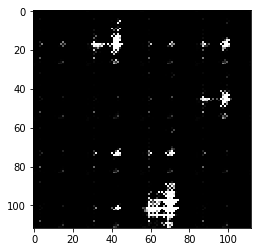

Timestamp 20170802-01-10-33.807 -  Epoch 1/2 -  Step 410 -  D Loss: 0.4312 - G Loss: 6.4061
Timestamp 20170802-01-10-44.309 -  Epoch 1/2 -  Step 420 -  D Loss: 0.4529 - G Loss: 2.7494
Timestamp 20170802-01-10-54.794 -  Epoch 1/2 -  Step 430 -  D Loss: 0.5357 - G Loss: 3.4331
Timestamp 20170802-01-11-05.285 -  Epoch 1/2 -  Step 440 -  D Loss: 0.4486 - G Loss: 2.8206
Timestamp 20170802-01-11-15.765 -  Epoch 1/2 -  Step 450 -  D Loss: 2.2944 - G Loss: 6.0978
Timestamp 20170802-01-11-26.559 -  Epoch 1/2 -  Step 460 -  D Loss: 0.4498 - G Loss: 3.1307
Timestamp 20170802-01-11-37.040 -  Epoch 1/2 -  Step 470 -  D Loss: 0.4574 - G Loss: 2.5113
Timestamp 20170802-01-11-47.514 -  Epoch 1/2 -  Step 480 -  D Loss: 0.5025 - G Loss: 3.0669
Timestamp 20170802-01-11-57.979 -  Epoch 1/2 -  Step 490 -  D Loss: 0.5188 - G Loss: 2.1761
Timestamp 20170802-01-12-08.691 -  Epoch 1/2 -  Step 500 -  D Loss: 0.4624 - G Loss: 3.4245


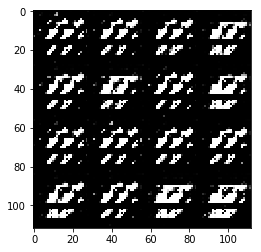

Timestamp 20170802-01-12-19.767 -  Epoch 1/2 -  Step 510 -  D Loss: 0.5053 - G Loss: 2.2337
Timestamp 20170802-01-12-30.320 -  Epoch 1/2 -  Step 520 -  D Loss: 0.3966 - G Loss: 3.8225
Timestamp 20170802-01-12-40.966 -  Epoch 1/2 -  Step 530 -  D Loss: 0.9283 - G Loss: 5.4065
Timestamp 20170802-01-12-51.486 -  Epoch 1/2 -  Step 540 -  D Loss: 0.4447 - G Loss: 3.2286
Timestamp 20170802-01-13-02.025 -  Epoch 1/2 -  Step 550 -  D Loss: 0.5205 - G Loss: 2.4351


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.